In [35]:
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [158]:
def whiten(X):
    X_mean = X.mean(axis=-1)
    X -= X_mean[:, np.newaxis]
    u, d, _ = np.linalg.svd(X, full_matrices=False)
    K = (u / d).T
    X1 = np.dot(K, X)
    X1 *= np.sqrt(X.shape[1])
    return X1, K

def w_update(weights, x, eta, l):
    n_sources, n_samples = x.shape
    block = int(np.floor(np.sqrt(n_samples / 3)))
    permute_index = np.random.permutation(n_samples)
    for start,stop in [(i*block,(i+1)*block) for i in range(int(n_samples/block))]+[(int(n_samples/block)*block,n_samples)]:
        block = stop-start
        unmixed = np.dot(weights, x[:, permute_index[start:stop]])
        logf = 1 - (2 / (1 + np.exp(-unmixed)))
        weights = weights + eta * np.dot(block * np.eye(n_sources) + np.dot(logf, unmixed.T), weights)   
    return weights, l*eta

def infomax(x):

    n_sources = x.shape[0]
    weights = np.random.uniform(0,1,(n_sources,n_sources))
    old_weights = np.copy(weights)
    d_weigths = np.zeros(n_sources)
    eta = 0.0001
    l = 0.97
    epsilon = 10e-12
    change = 1
    step = 1
    
    while step < 500 and change > epsilon:

        (weights, eta) = w_update(weights, x, eta, l)

        d_weigths = weights - old_weights
        change = np.linalg.norm(d_weigths)**2
        old_weights = np.copy(weights)

        if change < epsilon:
            print("Converged at step %d: learningrate %.1e, Wchange %.1e," % (step, eta, change))
            return (np.linalg.inv(weights), np.dot(weights, x), weights)

        step = step + 1
    print('Didnt converge.')
    return (np.linalg.inv(weights), np.dot(weights, x), weights)

def buildcorrelations(N, s, x):
    p = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            #print("i: "+str(i)+" j: "+str(j)+" corr:\n"+str((np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))))
            p[i, j] = (np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))[0,1]
    return p

def myplot(W, W2, n, x, s):    
    #retrieve shats - ^s
    shatb_decentered = np.dot(W, x)
    shatb_decentered2 = np.dot(W2, x)
    N = s.shape[0]
    #Check correlations, to check whcih source goes to which output channel
    mixcors = buildcorrelations(N, s, x)
    naturalcors = buildcorrelations(N, shatb_decentered, s)
    isflippedmixes = (mixcors[0,0] < mixcors[0,1]) and (mixcors[1,0] > mixcors[1,1])
    isflippednatural = (naturalcors[0,0] < naturalcors[0,1]) and (naturalcors[1,0] > naturalcors[1,1])

    ys = [(s, 'Original Sources', False), 
          (x, 'Mixed Sources', False), 
          (n, 'Whitened Mixes', False),
          (shatb_decentered, 'FastICA with logcosh', isflippednatural),
         (shatb_decentered2, 'FastICA with exp', isflippednatural)]
    
    ylimits = [-14,14]
    f, axarr = plt.subplots(len(ys), len(s))
    f.set_size_inches(5*len(s), len(ys)*5, forward=False) 
       
    for r in range(len(ys)):
        axarr[r, 0].set_ylabel(ys[r][1])
        for i in range(len(s)):
            axarr[r, i].plot(range(ys[r][0].shape[1]), ys[r][0][i])
            axarr[r, i].set_title("Source %d"%(i+1))

            
    plt.show()

In [159]:
t = np.arange(0,50,0.05)
s1 = 4*np.sin(t-3)
s2 = (t+5)%10
s3 = np.array([-14 if np.cos(2*ti)>0 else 0 for ti in t])
s = np.array([s1,s2,s3])

A = np.array([[2,-3,-4],[7,5,1],[-4,7,5]])
mixed = np.dot(A,s)

whitened, K = whiten(mixed)

ica = FastICA(whiten=False, max_iter=1000, tol=0.00001)
ica.fit(whitened.T)
W = ica.components_
W = np.dot(W, K)

ica2 = FastICA(whiten=False, max_iter=1000, tol=0.00001, fun='cube')
ica2.fit(whitened.T)
W2 = ica2.components_
W2 = np.dot(W2, K)

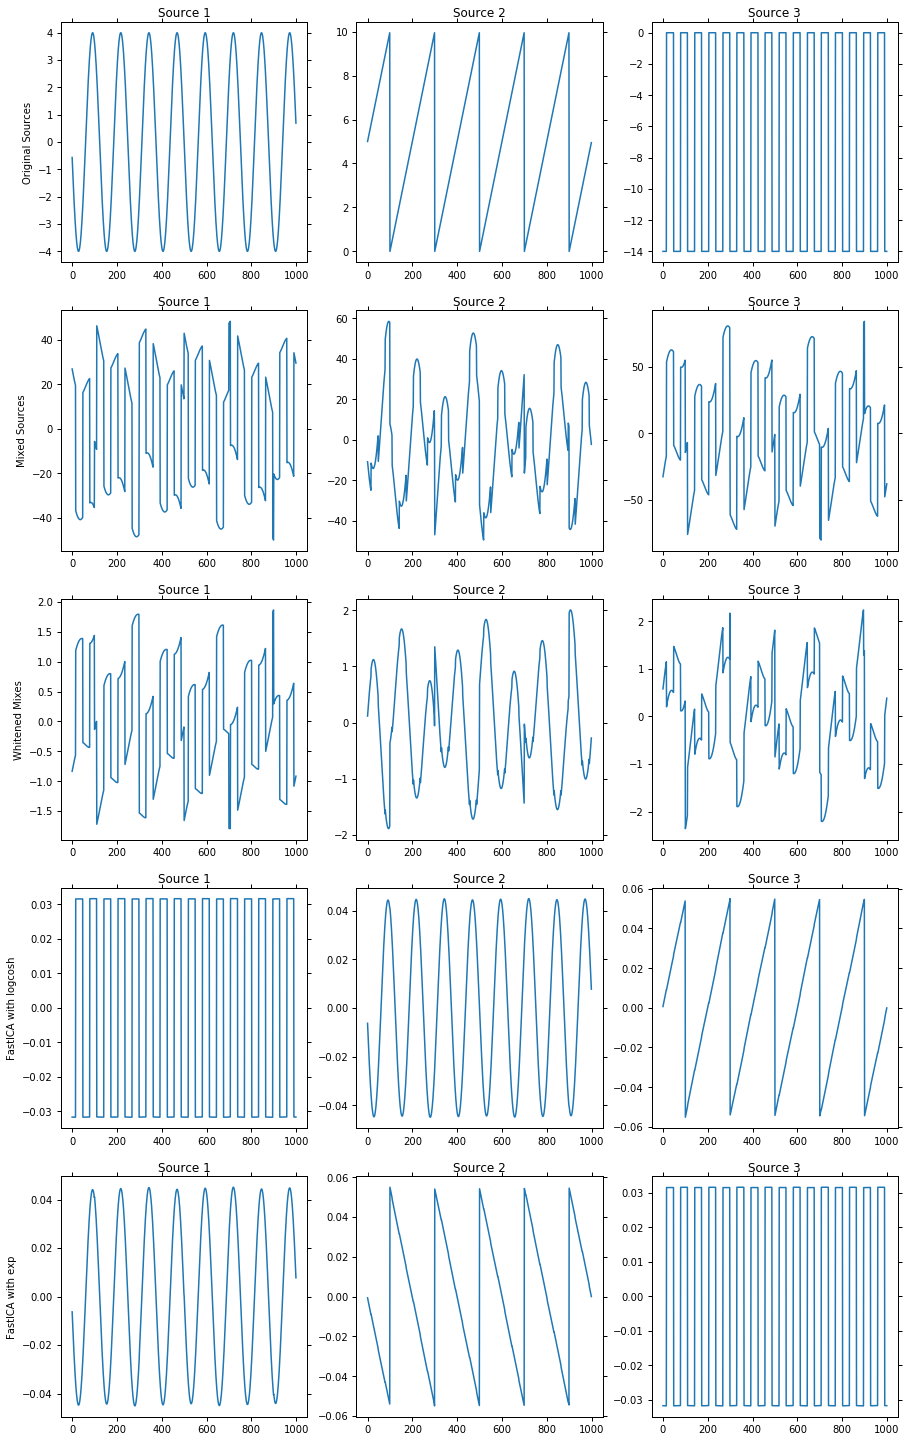

In [160]:
myplot(W, W2, whitened, mixed, s)

In [186]:
A = np.array([[0.999999999999992,1,1],[1,0.999999999999992,1],[1,1,0.999999999999992]])
mixed = np.dot(A,s)

whitened, K = whiten(mixed)

ica = FastICA(whiten=False, max_iter=1000, tol=0.00001)
ica.fit(whitened.T)
W = ica.components_
W = np.dot(W, K)

ica2 = FastICA(whiten=False, max_iter=1000, tol=0.00001, fun='exp')
ica2.fit(whitened.T)
W2 = ica2.components_
W2 = np.dot(W2, K)

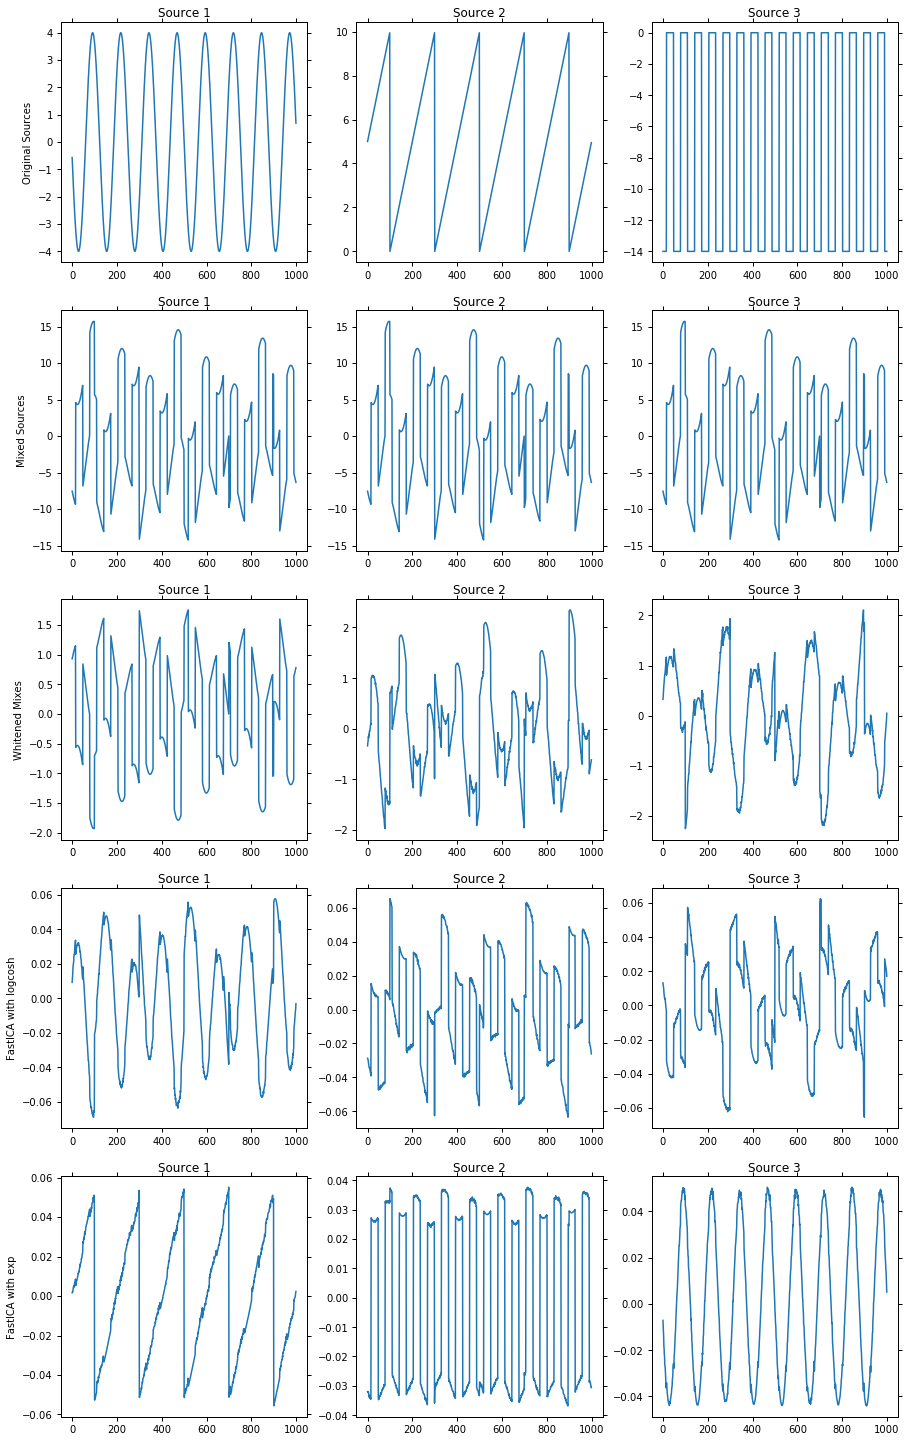

In [187]:
myplot(W, W2, whitened, mixed, s)

In [198]:
A = np.array([[2,-3,-4],[7,5,1],[-4,7,5]])
mixed = np.dot(A,s)
max_diff = mixed.max()-mixed.min()
n = np.random.normal(0,0.0001*max_diff,mixed.shape[1])
mixed = mixed + n

whitened, K = whiten(mixed)

ica = FastICA(whiten=False, max_iter=1000, tol=0.00001)
ica.fit(whitened.T)
W = ica.components_
W = np.dot(W, K)

ica2 = FastICA(whiten=False, max_iter=1000, tol=0.00001, fun='cube')
ica2.fit(whitened.T)
W2 = ica2.components_
W2 = np.dot(W2, K)

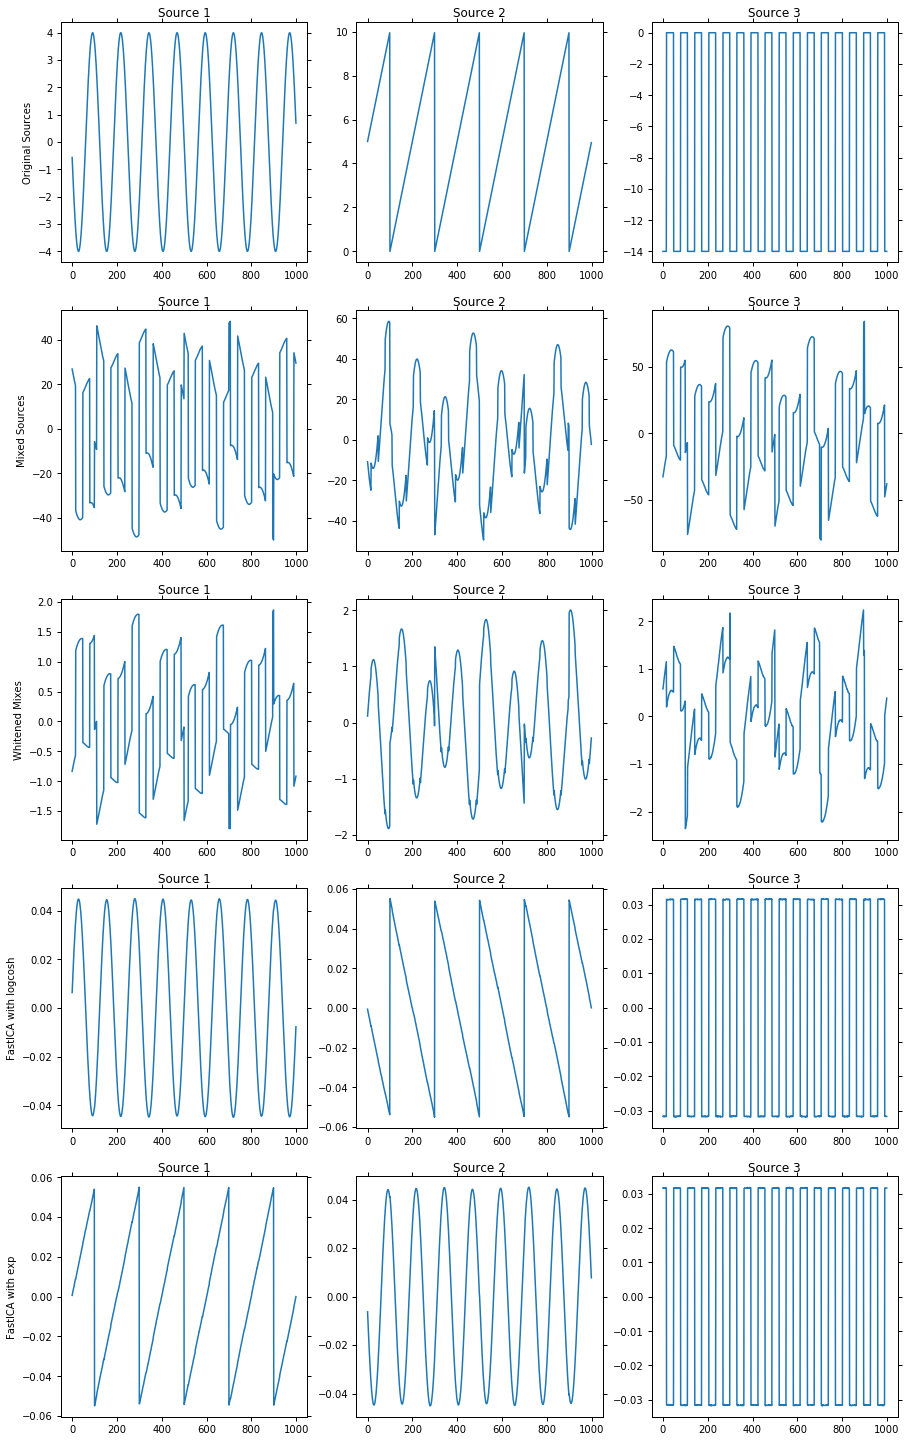

In [199]:
myplot(W, W2, whitened, mixed, s)

In [200]:
A = np.array([[2,-3,-4],[7,5,1],[-4,7,5]])

mixed = np.dot(A,s)
max_diff = mixed.max()-mixed.min()
n = np.random.normal(0,0.001*max_diff,mixed.shape[1])
mixed = mixed + n

whitened, K = whiten(mixed)

ica = FastICA(whiten=False, max_iter=1000, tol=0.00001)
ica.fit(whitened.T)
W = ica.components_
W = np.dot(W, K)

ica2 = FastICA(whiten=False, max_iter=1000, tol=0.00001, fun='cube')
ica2.fit(whitened.T)
W2 = ica2.components_
W2 = np.dot(W2, K)

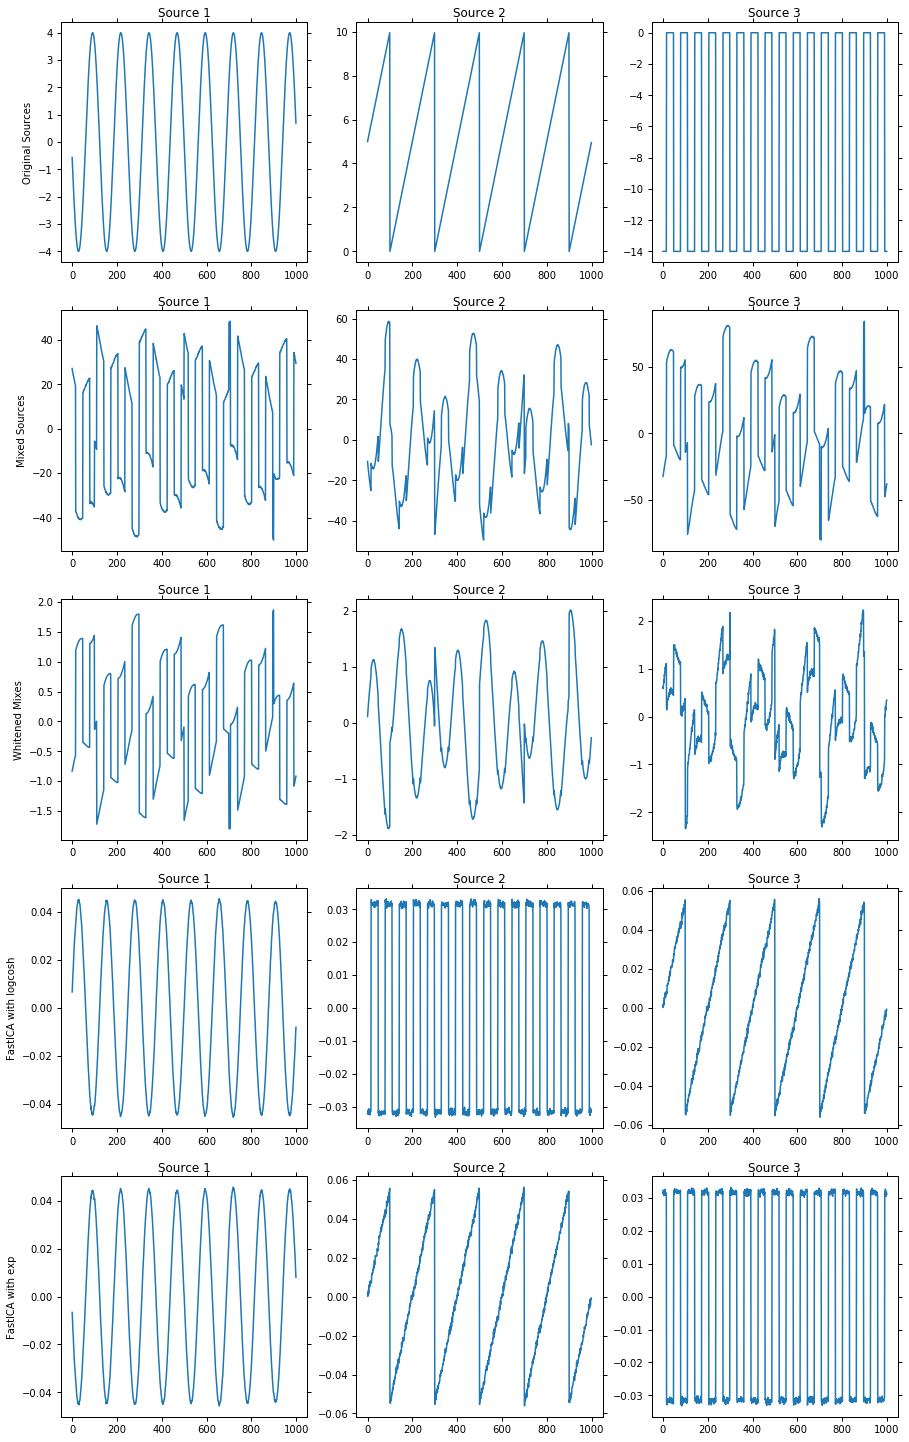

In [201]:
myplot(W, W2, whitened, mixed, s)

In [204]:
A = np.array([[2,-3,-4],[7,5,1],[-4,7,5]])

mixed = np.dot(A,s)
max_diff = mixed.max()-mixed.min()
n = np.random.normal(0,0.01*max_diff,mixed.shape)
mixed = mixed + n

whitened, K = whiten(mixed)

ica = FastICA(whiten=False, max_iter=1000, tol=0.00001)
ica.fit(whitened.T)
W = ica.components_
W = np.dot(W, K)

ica2 = FastICA(whiten=False, max_iter=1000, tol=0.00001, fun='cube')
ica2.fit(whitened.T)
W2 = ica2.components_
W2 = np.dot(W2, K)

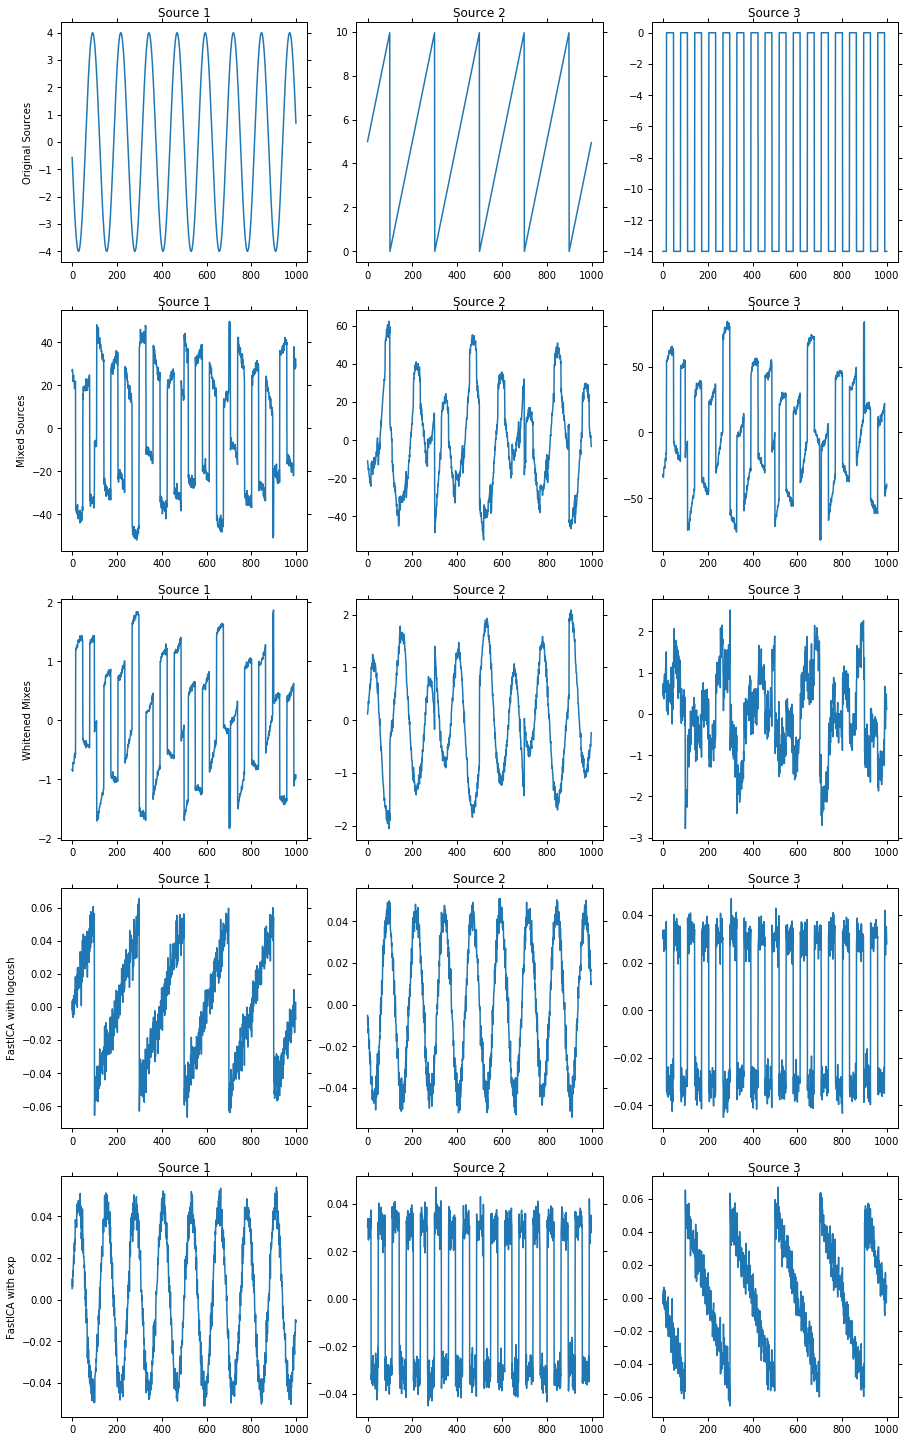

In [205]:
myplot(W, W2, whitened, mixed, s)

In [207]:
A = np.array([[2,-3,-4],[7,5,1],[-4,7,5]])

mixed = np.dot(A,s)
max_diff = mixed.max()-mixed.min()
n = np.random.normal(0,0.1*max_diff,mixed.shape)
mixed = mixed + n

whitened, K = whiten(mixed)

ica = FastICA(whiten=False, max_iter=1000, tol=0.00001)
ica.fit(whitened.T)
W = ica.components_
W = np.dot(W, K)

ica2 = FastICA(whiten=False, max_iter=1000, tol=0.00001, fun='cube')
ica2.fit(whitened.T)
W2 = ica2.components_
W2 = np.dot(W2, K)

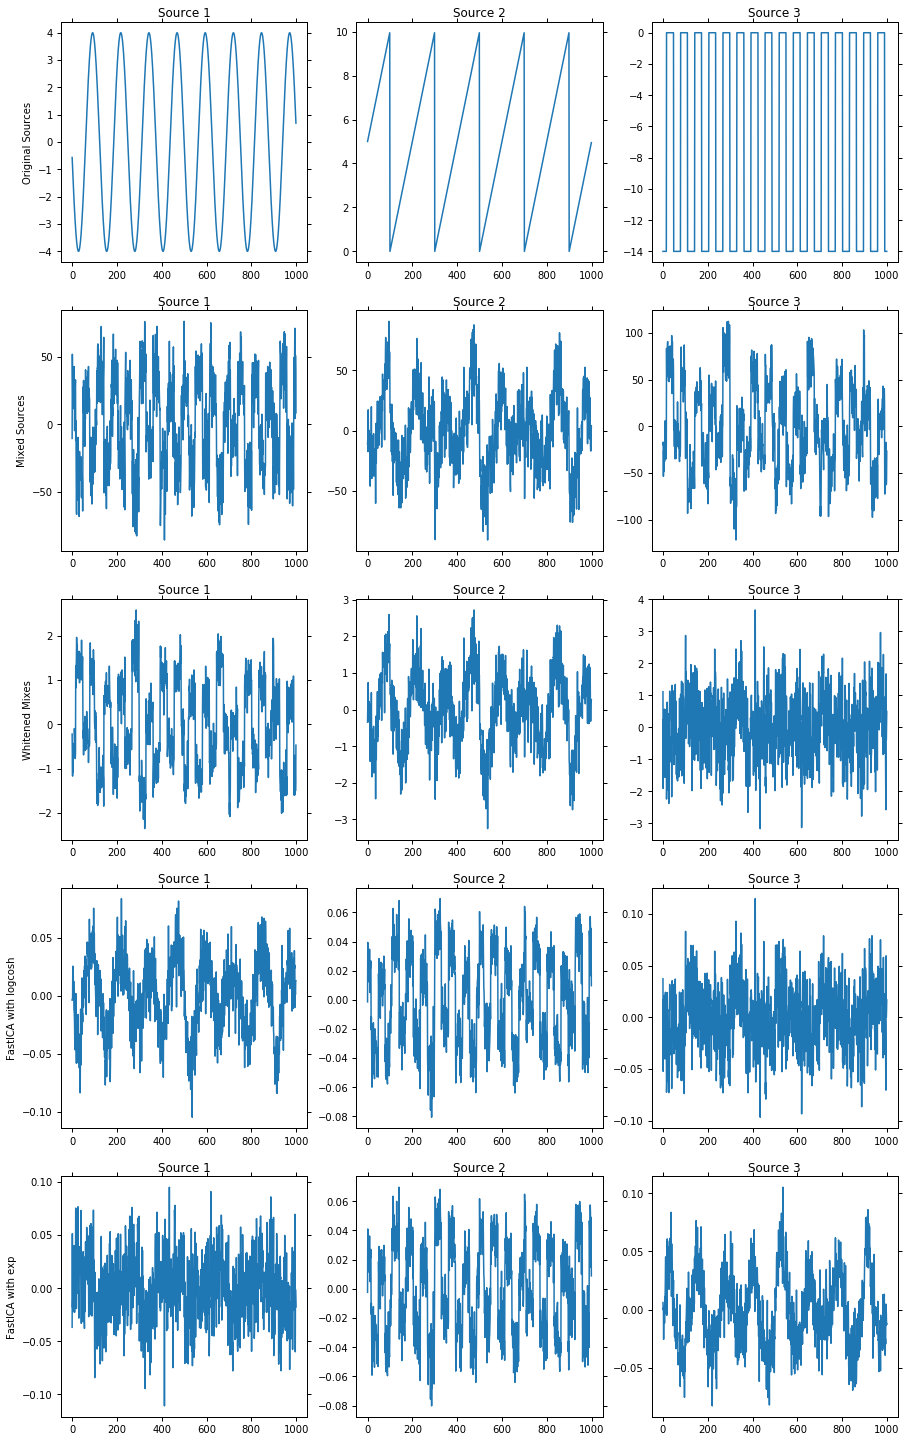

In [208]:
myplot(W, W2, whitened, mixed, s)